<a href="https://colab.research.google.com/github/cemreefe/cmpe493-project/blob/main/tfidf-cosine_similarity_cemre.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip3 install xmltodict

import os
import tarfile
import pandas as pd
import xmltodict
import json
import io   
import math
import pickle

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
def read_file(path):
  with open(path, 'r') as f:
    return f.read()

In [4]:
if not os.path.exists('drive/MyDrive/CMPE/CMPE493'):
  os.makedirs('drive/MyDrive/CMPE/CMPE493')

In [5]:
if not os.path.exists('drive/MyDrive/CMPE/CMPE493/topics-rnd5.xml'):
  !curl https://ir.nist.gov/covidSubmit/data/topics-rnd5.xml --output drive/MyDrive/CMPE/CMPE493/topics-rnd5.xml

if not os.path.exists('drive/MyDrive/CMPE/CMPE493/qrels-covid_d5_j0.5-5.txt'):
  !curl https://ir.nist.gov/covidSubmit/data/qrels-covid_d5_j0.5-5.txt --output drive/MyDrive/CMPE/CMPE493/qrels-covid_d5_j0.5-5.txt

if not os.path.exists('drive/MyDrive/CMPE/CMPE493/cord-19_2020-07-16.tar.gz'):
  !curl https://ai2-semanticscholar-cord-19.s3-us-west-2.amazonaws.com/historical_releases/cord-19_2020-07-16.tar.gz --output drive/MyDrive/CMPE/CMPE493/cord-19_2020-07-16.tar.gz

In [6]:
if not os.path.exists('2020-07-16'):
  tar = tarfile.open('drive/MyDrive/CMPE/CMPE493/cord-19_2020-07-16.tar.gz', "r:gz")
  tar.extractall()
  tar.close()

In [7]:
df_metadata = pd.read_csv('2020-07-16/metadata.csv')

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (1,4,5,6,13,14,15,16) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [8]:
del df_metadata['sha'], df_metadata['source_x'], df_metadata['doi'], df_metadata['pmcid'], df_metadata['pubmed_id'], df_metadata['license'], df_metadata['publish_time'], df_metadata['authors'], df_metadata['journal'], df_metadata['mag_id'], df_metadata['who_covidence_id'], df_metadata['arxiv_id'], df_metadata['pdf_json_files'], df_metadata['pmc_json_files'], df_metadata['url'], df_metadata['s2_id']

In [9]:
df_metadata[df_metadata['cord_uid'] == 'ug7v899j']

,cord_uid,title,abstract
0,ug7v899j,Clinical features of culture-proven Mycoplasma...,OBJECTIVE: This retrospective chart review des...


In [10]:
df_metadata.drop_duplicates(subset='cord_uid', keep='first', inplace=True)

In [11]:
df_metadata

,cord_uid,title,abstract
0,ug7v899j,Clinical features of culture-proven Mycoplasma...,OBJECTIVE: This retrospective chart review des...
1,02tnwd4m,Nitric oxide: a pro-inflammatory mediator in l...,Inflammatory diseases of the respiratory tract...
2,ejv2xln0,Surfactant protein-D and pulmonary host defense,Surfactant protein-D (SP-D) participates in th...
3,2b73a28n,Role of endothelin-1 in lung disease,Endothelin-1 (ET-1) is a 21 amino acid peptide...
4,9785vg6d,Gene expression in epithelial cells in respons...,Respiratory syncytial virus (RSV) and pneumoni...
...,...,...,...
192504,z4ro6lmh,Rapid radiological improvement of COVID-19 pne...,NaN
192505,hi8k8wvb,SARS E protein in phospholipid bilayers: an an...,Abstract We report on an anomalous X-ray refle...
192506,ma3ndg41,Italian Society of Interventional Cardiology (...,COVID‐19 pandemic raised the issue to guarante...
192507,wh10285j,"Nimble, Together: A Training Program's Respons...",NaN


In [12]:
topic_relevances = 'topic iter document_id judgement\n' + read_file('drive/MyDrive/CMPE/CMPE493/qrels-covid_d5_j0.5-5.txt')

df_relevances = pd.read_csv(  io.StringIO(topic_relevances)  , sep=" ")
del df_relevances['iter']

df_relevances

,topic,document_id,judgement
0,1,005b2j4b,2
1,1,00fmeepz,1
2,1,010vptx3,2
3,1,0194oljo,1
4,1,021q9884,1
...,...,...,...
69313,50,zvop8bxh,2
69314,50,zwf26o63,1
69315,50,zwsvlnwe,0
69316,50,zxr01yln,1


In [13]:
topics_obj = xmltodict.parse(read_file('drive/MyDrive/CMPE/CMPE493/topics-rnd5.xml'))
topics     = json.loads(json.dumps(topics_obj))

topics_dict = {}
for topic in topics['topics']['topic']:
  # a topic has the following fields:
  #  * @number
  #  * narrative
  #  * query
  #  * question
  topics_dict[topic['@number']] = topic['query'] + ' ' + topic['question'] + ' ' + topic['narrative']
  #topics_dict[topic['@number']] = topic['question']

In [14]:
len(topics_dict)

50

# Data so far

* `topics_dict` 
      has `topic-id` for keys, and topic description for values
* `df_relevances` 
      has the following three columns:
      topic	document-id	judgement
* `df_metadata`
      holds information about the documents
      has the following three columns (others are deleted):
      cord_uid	title	abstract


In [15]:
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
#stopwords.words('english')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [16]:
import numpy as np

docs = np.array(df_metadata)
contents = {}

for doc in docs:
  contents[doc[0]] = f'{doc[1]} {doc[2]}'

In [17]:
import string
import re
from nltk.stem.porter import PorterStemmer
porter_stemmer = PorterStemmer()
sw = stopwords.words('english')

def preprocess(s):
  s = s.casefold()
  s = s.translate(str.maketrans(string.punctuation, ' ' * len(string.punctuation)))
  s = re.sub("\d+", "", s) #Delete numbers
  s = ' '.join([porter_stemmer.stem(word) for word in s.split() if word not in sw and word != 'nan'])
  return s

In [18]:
'''
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(preprocessor=preprocess)
vectors = vectorizer.fit_transform(list(contents.values()) + list(topics_dict.values()))
'''

'\nfrom sklearn.feature_extraction.text import TfidfVectorizer\n\nvectorizer = TfidfVectorizer(preprocessor=preprocess)\nvectors = vectorizer.fit_transform(list(contents.values()) + list(topics_dict.values()))\n'

In [19]:
'''
doc_vectors = vectors[:-50]
topic_vectors = vectors[-50:]
'''

'\ndoc_vectors = vectors[:-50]\ntopic_vectors = vectors[-50:]\n'

In [20]:
from sklearn.feature_extraction.text import TfidfVectorizer

if not os.path.exists("drive/MyDrive/CMPE/CMPE493/doc_vectors.pickle"):
  doc_vectorizer = TfidfVectorizer(preprocessor=preprocess)
  doc_vectors = doc_vectorizer.fit_transform(list(contents.values()))
else:
  doc_vectorizer = pickle.load(open("drive/MyDrive/CMPE/CMPE493/doc_vectorizer.pickle", "rb"))
  doc_vectors = pickle.load(open("drive/MyDrive/CMPE/CMPE493/doc_vectors.pickle", "rb"))

print(len(doc_vectorizer.vocabulary_))


145387


In [21]:
odd_topic_contents  = { key:topics_dict[key] for key in topics_dict.keys() if (int(key) % 2 == 1) }
even_topic_contents = { key:topics_dict[key] for key in topics_dict.keys() if (int(key) % 2 == 0) }

In [22]:
if not os.path.exists("drive/MyDrive/CMPE/CMPE493/topic_vectors.pickle"):
  topic_vectorizer = TfidfVectorizer(preprocessor=preprocess,vocabulary=doc_vectorizer.vocabulary_)
  topic_vectors = topic_vectorizer.fit_transform(odd_topic_contents.values())
else:
  topic_vectors = pickle.load(open("drive/MyDrive/CMPE/CMPE493/topic_vectors.pickle", "rb"))


In [23]:
if not os.path.exists("drive/MyDrive/CMPE/CMPE493/test_topic_vectors.pickle"):
  test_topic_vectorizer = TfidfVectorizer(preprocessor=preprocess,vocabulary=doc_vectorizer.vocabulary_)
  test_topic_vectors = test_topic_vectorizer.fit_transform(even_topic_contents.values())
else:
  test_topic_vectors = pickle.load(open("drive/MyDrive/CMPE/CMPE493/test_topic_vectors.pickle", "rb"))


In [24]:
doc_vectors.shape

(191175, 145387)

In [25]:
doc_vectors_dict = {
    docs[i][0] : doc_vectors[i]
    for i in range(0,len(docs))
}

In [26]:
topic_vectors_dict = {
    key : topic_vectors[i]
    for i, key in enumerate(odd_topic_contents.keys())
}

test_topic_vectors_dict = {
    key : test_topic_vectors[i]
    for i, key in enumerate(even_topic_contents.keys())
}

In [27]:
from sklearn.metrics.pairwise import cosine_similarity
#Takes random doc_id and prints most relevant topic
ex_document = df_metadata.sample().cord_uid.to_string().split()[1]
similarity = cosine_similarity(doc_vectors_dict[ex_document],topic_vectors).flatten()

print(ex_document)
print(similarity)
print(np.max(similarity))
print(np.argmax(similarity))
print(contents[ex_document])
print(topics_dict[str(np.argmax(similarity) + 1)])

g5yhvmee
[0.03086548 0.05528745 0.08727579 0.         0.02282259 0.02417359
 0.         0.         0.         0.05453671 0.         0.01517287
 0.00790881 0.03276885 0.04048514 0.         0.01959893 0.01550983
 0.04494033 0.03643197 0.01337268 0.02534998 0.03471769 0.01696731
 0.02503211]
0.08727578639197947
2
ACE2 and prognosis of COVID‐19. Insights from Bartter's and Gitelman's syndromes patients The relationship between Renin‐Angiotensin system (RAS) and COVID‐19 pandemic and, in particular, RAS as part of the CoV‐2 infection process via Angiotensin Converting Enzyme 2 (ACE2), the entry point of SARS‐CoV‐2, has resulted in conflicting suggestions regarding how RAS and its role(s) should inform treating COVID‐19. ACE inhibitors or angiotensin II (Ang)‐type 1 receptor blockers (ARBs), in fact, have been suggested to be avoided as they potentially upregulate ACE2 (1) and, conversely, there are suggestions that ARBs might be beneficial (2) as SARS‐CoV‐2 causing ACE2 downregulation slows

In [28]:
df_evaluation = df_relevances.copy()

In [29]:
# create a dataframe with each topic and document pair

df_nonex_rows = []
for topic in set(df_relevances["topic"]):
  for document_id in set(df_metadata["cord_uid"]):
    
    df_nonex_rows.append(
      {
       "topic":       topic, 
       "document_id": document_id, 
       "judgement":   -1

      }
    )
df_nonexistent = pd.DataFrame(df_nonex_rows)

In [30]:
df_evaluation = df_evaluation.append(df_nonexistent, ignore_index=True)

In [31]:
# drop duplicates so that if the document has a judgement 
df_evaluation = df_evaluation.drop_duplicates(subset=['topic', 'document_id'], keep='first')


In [32]:
# drop odd numbered
df_evaluation = df_evaluation.drop(df_evaluation[df_evaluation.topic.map(int) % 2 == 1].index)

In [33]:
df_evaluation

,topic,document_id,judgement
1647,2,01goni72,2
1648,2,01yc7lzk,0
1649,2,02cy1s8x,0
1650,2,02f0opkr,0
1651,2,03h85lvy,2
...,...,...,...
9628063,50,dv5vl5tj,-1
9628064,50,hczet7h3,-1
9628065,50,9rlkqfde,-1
9628066,50,f6jznntd,-1


In [34]:
ids_before = list(df_evaluation['document_id'])

In [35]:
test_topic_vectors_dict_keys = list(test_topic_vectors_dict.keys())
test_topic_vectors_dict_vals = list(test_topic_vectors_dict.values())

doc_vector_dict_keys = list(doc_vectors_dict.keys())
doc_vector_dict_vals = list(doc_vectors_dict.values())

In [36]:
%%time

calcsim = [
  cosine_similarity(test_topic_vectors_dict[key], doc_vectors)
  for key in test_topic_vectors_dict_keys          
]

CPU times: user 11.2 s, sys: 268 ms, total: 11.5 s
Wall time: 11.6 s


In [37]:
calculated_similarities = {
    key: {
      dockey: calcsim[i][0][j]
      for j, dockey in enumerate(doc_vector_dict_keys)
    }
    for i, key in enumerate(test_topic_vectors_dict_keys)
}

In [38]:
df_evaluation['cosine_similarity'] = df_evaluation.apply(
    lambda r: calculated_similarities[str(r.topic)][r.document_id],
    axis=1
)

In [39]:
ids_after = list(df_evaluation['document_id'])

In [40]:
ids_before == ids_after

True

In [41]:
stuff = np.abs(np.array(df_evaluation.judgement) - np.array(df_evaluation.cosine_similarity)*2)

In [42]:
np.mean(stuff)

1.0333178870827993

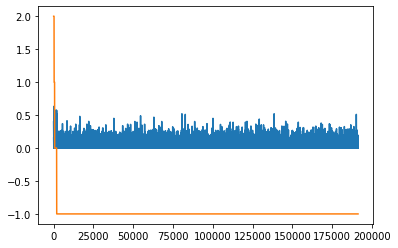

In [43]:
i = 4

similarities = np.array(df_evaluation[df_evaluation['topic'] == i].sort_values(by=["judgement"],ascending=False).cosine_similarity)

import matplotlib.pyplot as plt
plt.plot(similarities)
plt.plot(np.array(df_evaluation[df_evaluation['topic'] == i].sort_values(by=["judgement"],ascending=False).judgement))

In [44]:
import pickle
pickle.dump(doc_vectors, open("drive/MyDrive/CMPE/CMPE493/doc_vectors.pickle", "wb"))
pickle.dump(doc_vectorizer, open("drive/MyDrive/CMPE/CMPE493/doc_vectorizer.pickle", "wb"))
pickle.dump(topic_vectors, open("drive/MyDrive/CMPE/CMPE493/topic_vectors.pickle", "wb"))
pickle.dump(test_topic_vectors, open("drive/MyDrive/CMPE/CMPE493/test_topic_vectors.pickle", "wb"))

In [45]:
#Prepare results
df_results = df_evaluation.copy()
df_results.insert(1, 'iter', 0)
df_results.insert(3, 'rank', 0)
del df_results['judgement']
df_results.insert(5, 'run_id', 0)

In [46]:
df_results

,topic,iter,document_id,rank,cosine_similarity,run_id
1647,2,0,01goni72,0,0.042595,0
1648,2,0,01yc7lzk,0,0.079551,0
1649,2,0,02cy1s8x,0,0.058343,0
1650,2,0,02f0opkr,0,0.114825,0
1651,2,0,03h85lvy,0,0.000000,0
...,...,...,...,...,...,...
9628063,50,0,dv5vl5tj,0,0.000000,0
9628064,50,0,hczet7h3,0,0.000000,0
9628065,50,0,9rlkqfde,0,0.010345,0
9628066,50,0,f6jznntd,0,0.000000,0


In [47]:
df_results.to_csv('results.csv', sep=' ', index=False, header=False)